# Import packages

In [1]:
import pandas as pd

import warnings 
warnings.filterwarnings('ignore')

import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose

from modules.Utils.utils import loadFromDB, strategyTester


# Get Data

In [18]:
SYMBOL= 'BTC'
df =loadFromDB(SYMBOL,'1h',True)
df.head()

,Open,High,Low,Close,Volume,Timestamp
Date,,,,,,
2020-06-01 00:00:00,9448.27,9508.57,9421.67,9498.31,1742.125917,1590969600
2020-06-01 01:00:00,9498.78,9570.00,9465.30,9551.58,2064.378210,1590973200
2020-06-01 02:00:00,9551.17,9568.61,9526.87,9530.67,1984.956728,1590976800
2020-06-01 03:00:00,9531.70,9571.66,9514.65,9555.79,1620.638978,1590980400
2020-06-01 04:00:00,9556.14,9619.00,9541.96,9549.02,2787.512219,1590984000


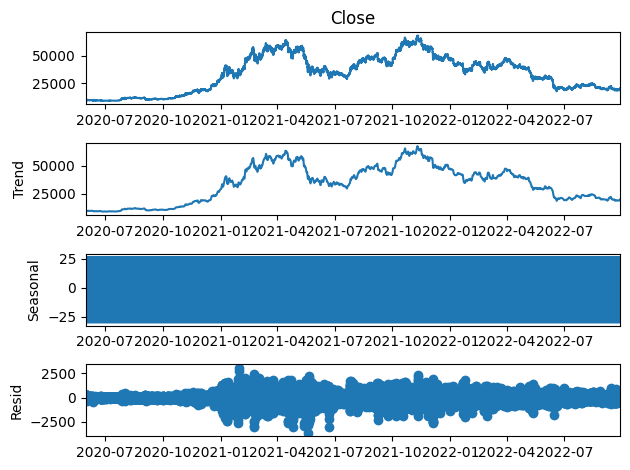

In [19]:
result = seasonal_decompose(df.Close,model='additive',extrapolate_trend='freq')
fig = result.plot()

Period : [2020-06-01 01:00:00] -> [2022-09-27 12:00:00]
Starting balance : 1000 $

----- General Informations -----
Final balance : 43092155.85 $
Performance vs US Dollar : 4309115.59 %
Buy and Hold Performence : 112.96 %
Performance vs Buy and Hold : 3814681.69 %
Best trade : +29.43 %, the 2021-01-08 23:00:00
Worst trade : -4.31 %, the 2021-01-03 17:00:00
Worst drawBack : -10.0 %
Total fees :  5616594.39 $

----- Trades Informations -----
Total trades on period : 739
Number of positive trades : 460
Number of negative trades :  279
Trades win rate ratio : 62.25 %
Average trades performance : 1.59 %
Average positive trades : 2.99 %
Average negative trades : -0.73 %

----- Plot -----


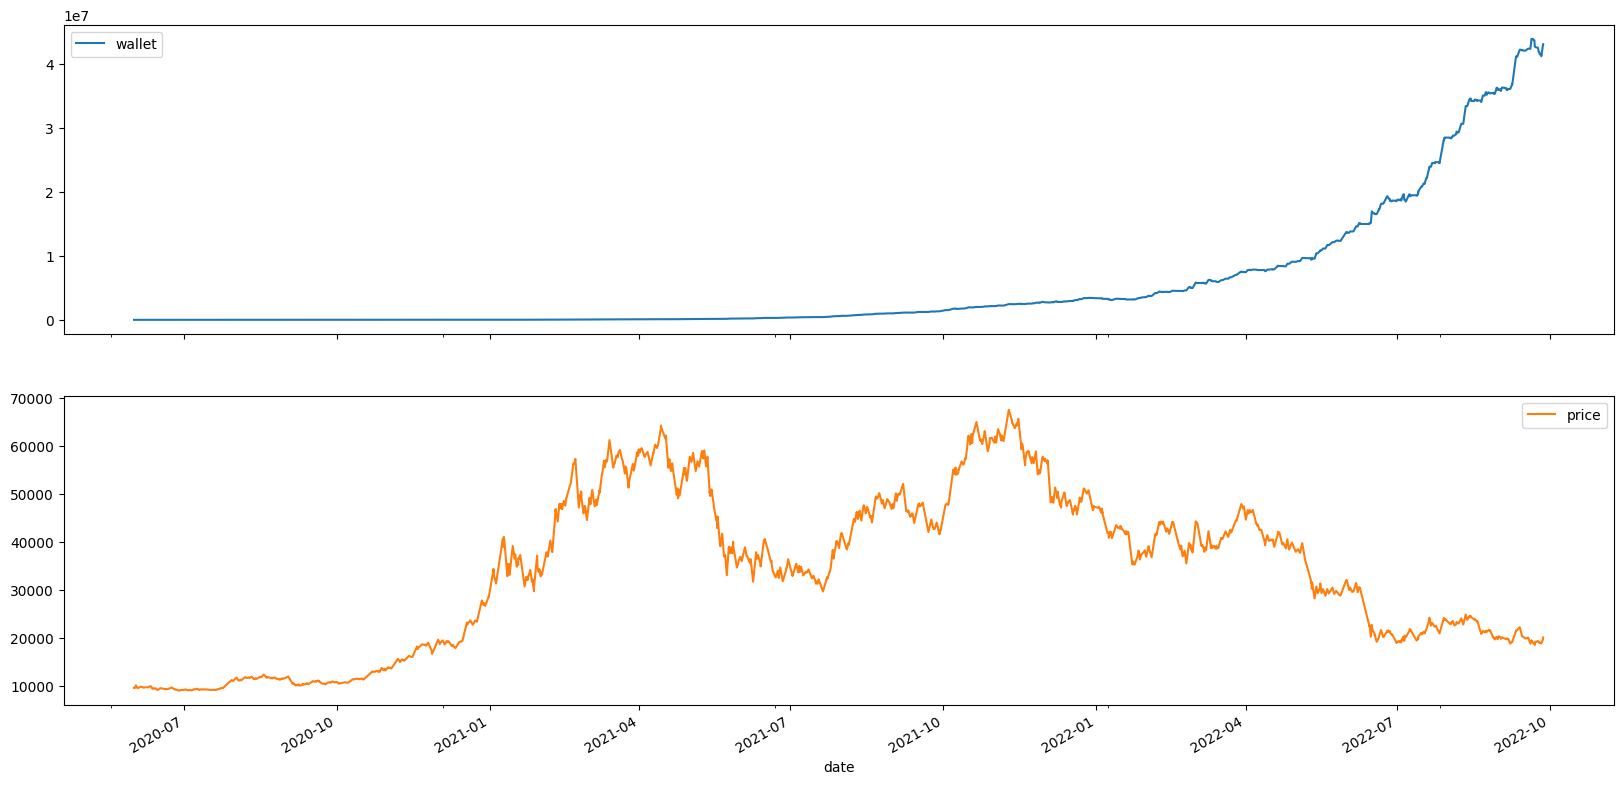

In [20]:
df['Trend'] = result.trend
df['Trend_diff'] = df.Trend.diff(1)
df.dropna(inplace=True)

def buyCondition(row:pd.Series, previous_row:pd.Series=None)->bool:
    return True if row.Trend_diff>0 else False

def sellCondition(row:pd.Series, previous_row:pd.Series=None)->bool:
    return True if row.Trend_diff<0 else False

strategyTester(df,buyCondition,sellCondition,equity=1000)

Testing strategy : 
Period : [2022-08-19 23:15:00] -> [2022-09-27 12:00:00]
Starting balance : 1000 $

----- General Informations -----
Final balance : 1025.34 $
Performance vs US Dollar : 2.53 %
Buy and Hold Performence : -20.18 %
Performance vs Buy and Hold : -112.56 %
Best trade : +6.36 %, the 2022-09-09 06:45:00
Worst trade : -3.9 %, the 2022-09-02 19:45:00
Worst drawBack : -5.0 %
Total fees :  25.26 $

----- Trades Informations -----
Total trades on period : 18
Number of positive trades : 9
Number of negative trades :  9
Trades win rate ratio : 50.0 %
Average trades performance : 0.23 %
Average positive trades : 1.36 %
Average negative trades : -0.91 %

----- Plot -----


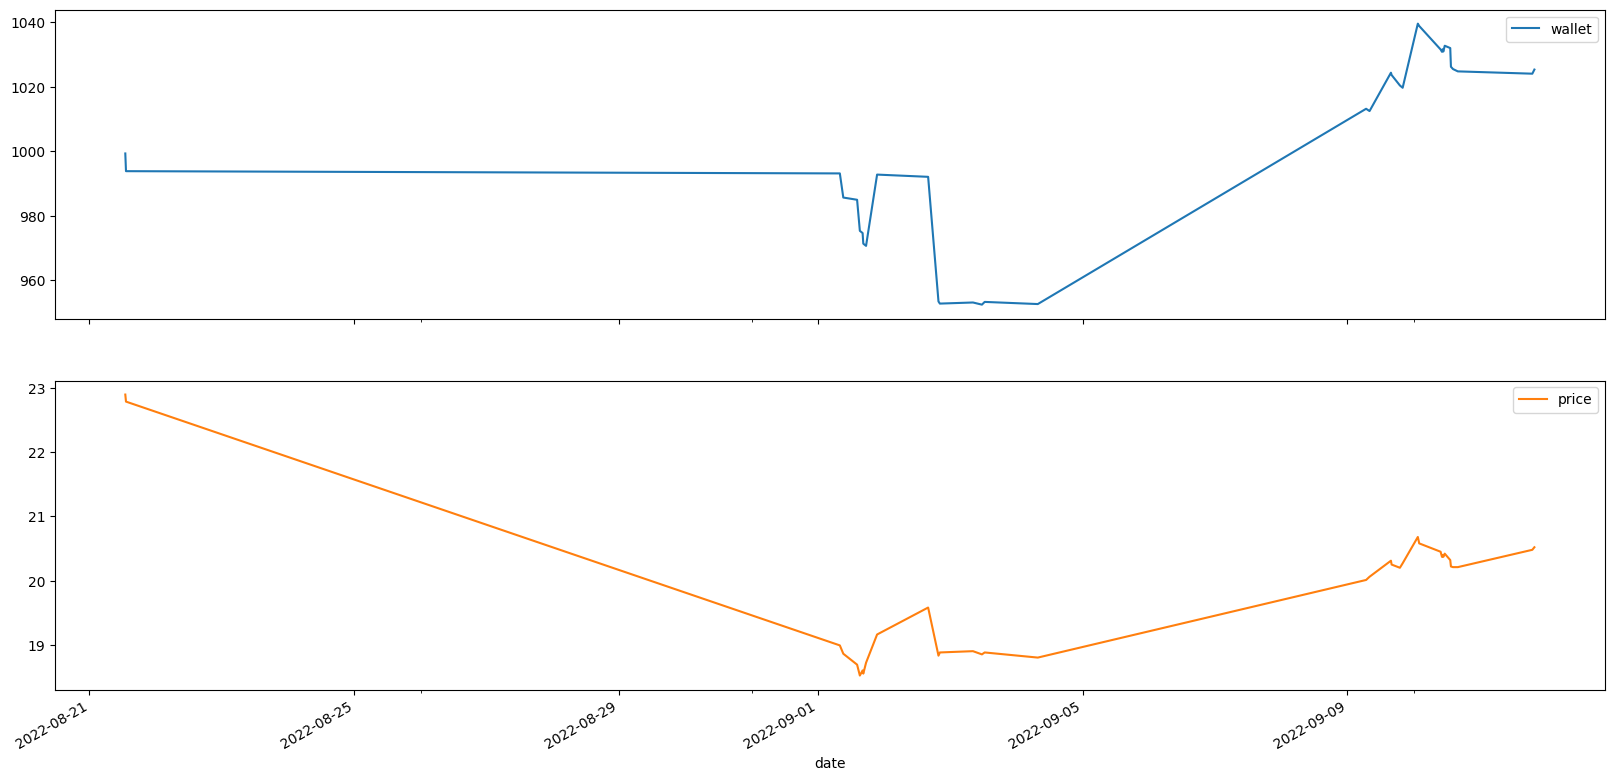

In [12]:
from concurrent.futures import ThreadPoolExecutor, as_completed
from multiprocess import cpu_count

SYMBOL= 'AVAX'
df = loadFromDB(SYMBOL,'15m',False).iloc[-4000:]

df_final = pd.DataFrame()

def process_one_row(df_i):
    df_i['Trend'] = seasonal_decompose(df.Close,model='additive',extrapolate_trend='freq',period=60*15).trend
    df_i['Trend_diff'] = df_i.Trend.diff(1)
    df.dropna(inplace=True)
    return df_i.iloc[-1]
    
with ThreadPoolExecutor(max_workers=cpu_count()) as executor:
    processes = [executor.submit(process_one_row, df.iloc[i-300:i]) for i in range(300,len(df))]

for task in as_completed(processes):
    df_final = df_final.append(task.result())
    
df_final.sort_index(inplace=True)

print('Testing strategy : ')
def buyCondition(row:pd.Series, previous_row:pd.Series=None)->bool:
    return True if row.Trend_diff>0 else False

def sellCondition(row:pd.Series, previous_row:pd.Series=None)->bool:
    return True if row.Trend_diff<0 else False

strategyTester(df_final,buyCondition,sellCondition,equity=1000)